# Homework 3

The goal of this assignment was to determine which customers would subscribe to a bank term deposit based on information about a marketing call campaign. We used a variety of classifier algorithms to build a model that, upon input of various characteristics of a phone call to a customer, would predict whether that customer would subscribe.

This is an updated version of our assignment submission.

### Import Libraries, Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.sparse import hstack
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import mutual_info_classif, SelectPercentile, VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data = pd.read_csv('data.csv')
data.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,...,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,...,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,...,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,...,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,...,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


### Exploration and Preparation

##### Data Cleaning

First, we separated the 'subscribed' feature as the target variable and encoded it in binary form.

In [3]:
subscribed = data['subscribed']
data.drop(['subscribed'], axis=1, inplace=True)
subscribed.replace(['yes', 'no'], [1, 0], inplace=True)
print("Percentage of customers who subscribed: {}".format((float(subscribed.sum()) / subscribed.shape[0])*100))

Percentage of customers who subscribed: 11.265553869499241


Since only about 11% of customers subscribed, the dataset is rather imbalanced and we accounted for this in our analysis.

For most features, we treated 'unknown' values as another variable. However, for the 'prev_days' feature (how many days since the client was previously contacted), over 95% of the observations were 999, meaning the client had not previously been contacted. We decided to convert this into a variable encoding the number of weeks since the customer was previously contacted, and encoded 'Never' for the 999 values.

In [4]:
data['prev_days'].value_counts()

999    31707
3        373
6        332
4        105
9         55
7         48
2         46
12        45
5         42
10        40
13        26
11        23
1         19
15        18
14        17
8         13
0         11
16        10
17         5
18         4
19         3
22         3
21         2
26         1
20         1
27         1
Name: prev_days, dtype: int64

In [5]:
data['prev_weeks'] = pd.cut(data['prev_days'], bins = [0, 7, 14, 21, 30, 1000], 
                             labels = ["1", "2", "3", "4", "Never"], include_lowest=True)

In [6]:
data.prev_weeks.value_counts()

Never    31707
1          976
2          219
3           43
4            5
Name: prev_weeks, dtype: int64

Since the 'duration' feature was leaky, we removed it from the analysis.

In [7]:
data.drop(['duration', 'prev_days'], axis=1, inplace=True)

Finally, to aid in analysis later, we reorder the columns such that the continuous columns are at the front.

In [8]:
categorical_cols = ['job', 'marital_status', 'education', 'credit_default', 'housing', 'loan', 'contact', 'month', 
                    'day_of_week', 'prev_outcomes', 'prev_weeks']
continuous_cols = ['age', 'campaign', 'prev_contacts', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 
                   'euribor3m', 'nr_employed']

In [9]:
data_reorder = pd.concat((data[continuous_cols], data[categorical_cols]), axis=1)

##### Train-Test Split

Here, we split off a test set and a cross-validation set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_reorder, subscribed, stratify=subscribed, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

##### Distributions

Next, we plot the distribution of each feature.

In [11]:
def plot_distributions(data, columns, bins):
    fig, axes = plt.subplots(len(columns), figsize=(20,1.7*len(columns)))
    fig.subplots_adjust(hspace=1.5)
    axes = axes.ravel()
    for col in range(len(columns)):
        if bins==None:
            labels = data[columns[col]].value_counts().index
            y_pos = np.arange(len(labels))
            axes[col].bar(y_pos, data[columns[col]].value_counts(), align='center')
            axes[col].set_xticks(y_pos)
            axes[col].set_xticklabels(labels)
        else:
            axes[col].hist(data[columns[col]], bins = bins)
        axes[col].set_title(columns[col])

    plt.show()

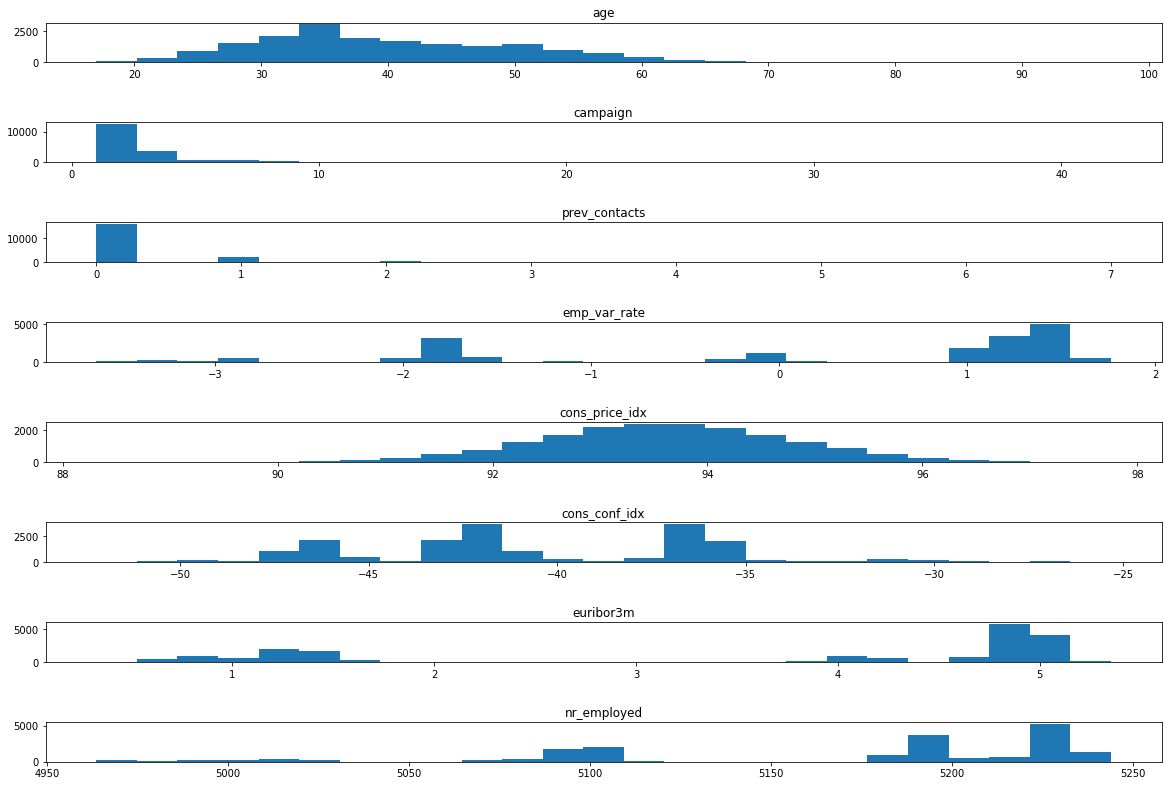

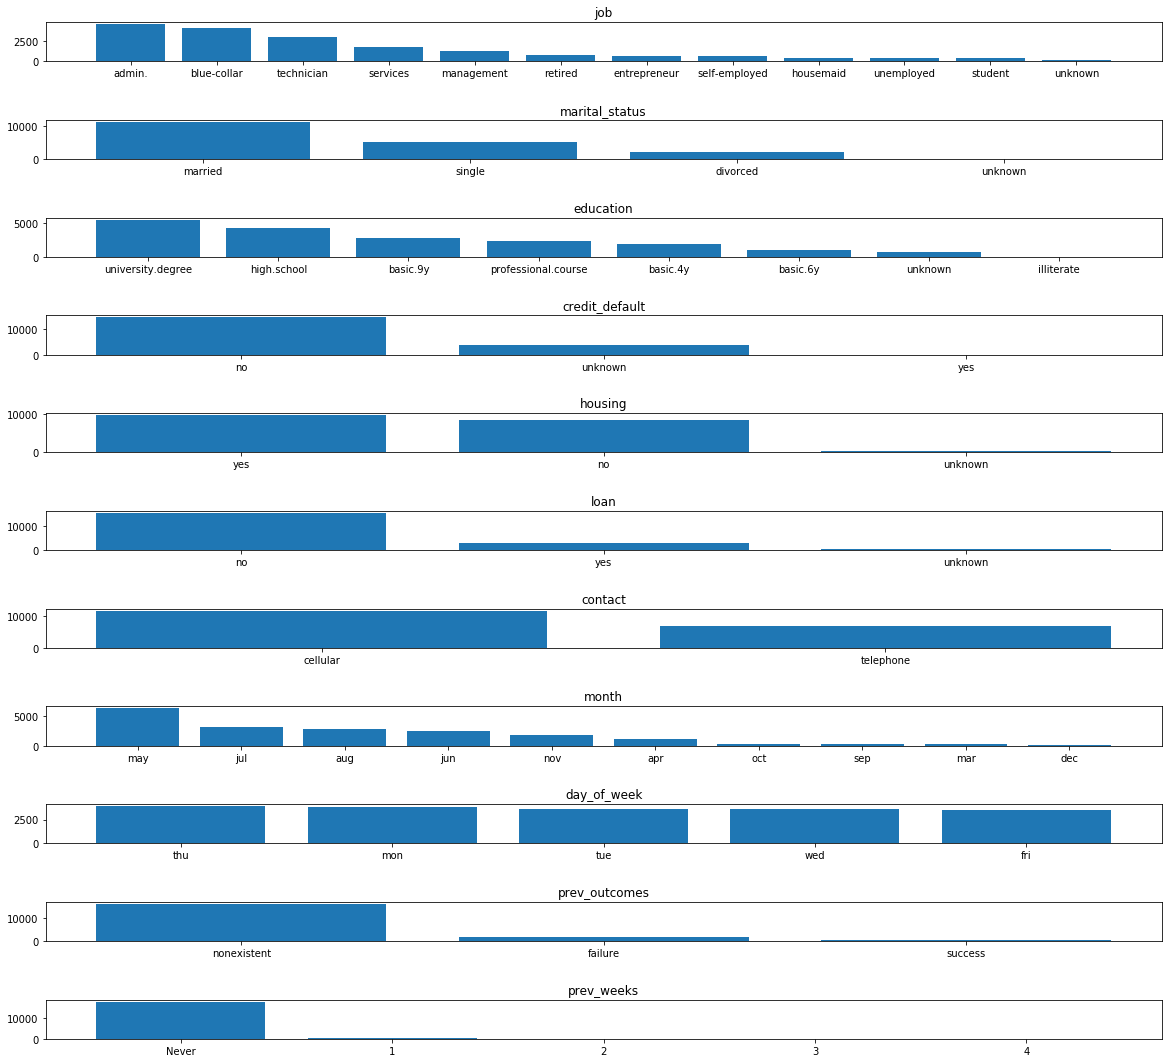

In [12]:
plot_distributions(X_train, continuous_cols, bins=25)
plot_distributions(X_train, categorical_cols, bins=None)

##### Mutual Information

To see which features are the most predictive, we plot the mutual information of each feature. This requires creating dummy variables for the categorical features, which we do briefly here for the purposes of this plot but redo later.

In [13]:
def plot_mutual_info(data, columns):
    inds = np.argsort(data)
    plt.figure(figsize = (10,15))
    plt.barh(np.arange(len(data)), np.log(np.array(data)[inds] + 1))
    plt.yticks(np.arange(len(data)), np.array(columns)[inds])
    plt.ylim(0, len(data))
    plt.xlabel('Mutual Information')

In [14]:
mi_continuous = mutual_info_classif(X_train[continuous_cols], y_train, discrete_features=False, n_neighbors = 3, 
                                    random_state=42)

categorical_train_dummies = pd.get_dummies(X_train[categorical_cols])
mi_categorical = mutual_info_classif(categorical_train_dummies, y_train, discrete_features=True, n_neighbors = 3, 
                                     random_state=42)

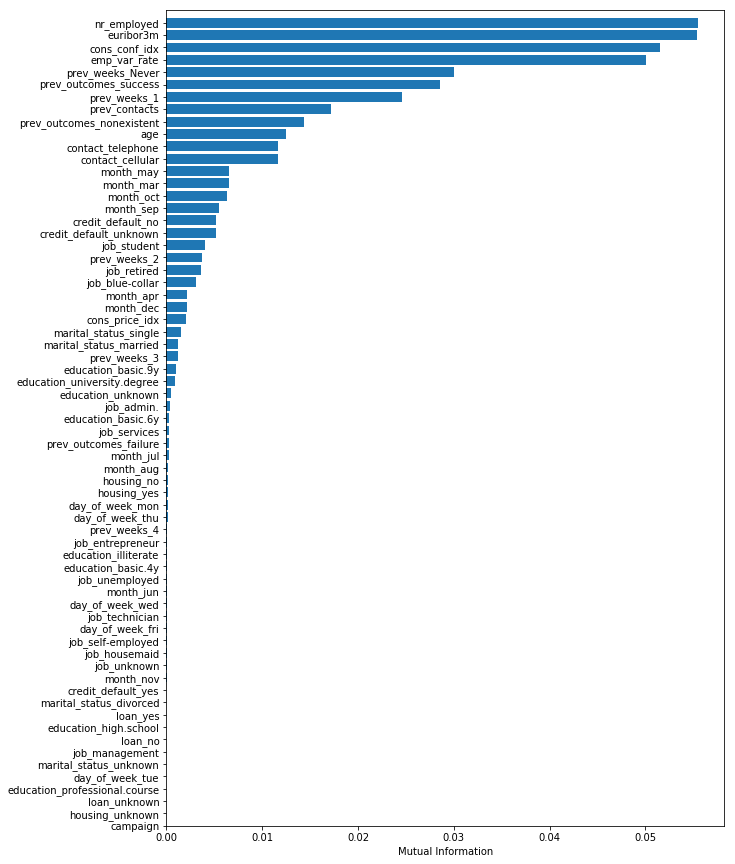

In [15]:
mutual_info = mi_continuous.tolist() + mi_categorical.tolist()
mutual_info_columns = X_train[continuous_cols].columns.tolist() + categorical_train_dummies.columns.tolist()
plot_mutual_info(mutual_info, mutual_info_columns)

##### PCA

To look for further underlying structure in the data, we perform PCA on the whole dataset. First, we scale the continuous features to mean 0 and standard deviation 1, and use label encoding and then one-hot encoding on the categorical features.

In [16]:
le = LabelEncoder()
for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_cv[col] = le.transform(X_cv[col])
    X_test[col] = le.transform(X_test[col])

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
X_whole = pd.concat((X_train, X_cv, X_test))
y_whole = pd.concat((y_train, y_cv, y_test))
X_whole, y_whole = shuffle(X_whole, y_whole, random_state=42)

In [18]:
X_scaled = StandardScaler().fit_transform(X_whole[continuous_cols])
X_onehot = OneHotEncoder(handle_unknown='ignore').fit_transform(X_whole[categorical_cols])
X_mapped = hstack((X_scaled, X_onehot)).toarray()

In [19]:
pca_mapped = PCA(n_components=3)
X_pca_mapped = pca_mapped.fit_transform(X_mapped)

In [26]:
def plot_PCA(n_components, X_pca, y_whole):
    combs = list(itertools.combinations(range(n_components), 2))
    
    fig = plt.figure(figsize=(15,15))
    fig.subplots_adjust(wspace=0.3)
    
    key = {0: ('#1b9e77', 'no'), 1: ('#d95f02', 'yes')}
    labels = {0: 'First Principal Component', 1: 'Second Principal Component', 2: 'Third Principal Component'}
    
    for i in range(1,len(combs)+1):
        ax = fig.add_subplot(3,3,i)
        comb = combs[i-1]
        ax.scatter(X_pca[:,comb[0]], X_pca[:,comb[1]], c=[key[index][0] for index in y_whole], s=50)
        ax.set_xlabel(labels[comb[0]])
        ax.set_ylabel(labels[comb[1]])
            
    plt.show()

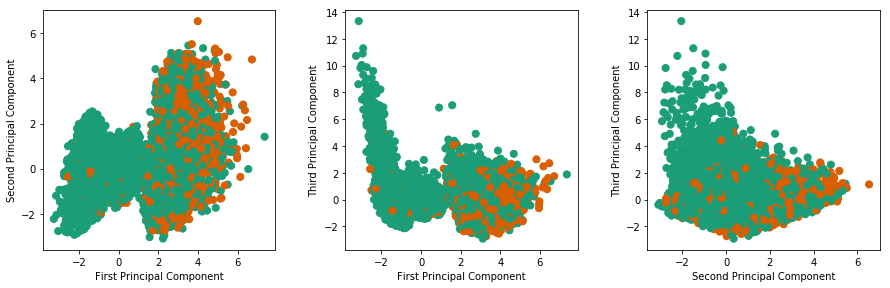

In [27]:
plot_PCA(3, X_pca_mapped, y_whole)

The results of the PCA don't reveal a very significant pattern - while there do seem to be groups of data that are much more unlikely to subscribe, the subscribers don't seem to be easily separable.

### Individual Models

The next step was to run individual models to see how they would perform. For each model, we perform One Hot Encoding on our categorical features and scale the continuous features. We then use random undersampling to deal with the imbalance of classes while reducing the size of the dataset, and select the best features according to mutual_information. Finally, we calculate second-degree polynomial features and remove unnecessary features by variance.

We used grid search to find the best parameters for each model based on ROC area under the curve.

In [28]:
mask_cat = [x in categorical_cols for x in X_train.columns.tolist()]

In [29]:
class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy, with_mean, with_std)

    def fit(self, X, y=None):
        self.scaler.fit(X.toarray()[:,:8], y)
        return self

    def transform(self, X, y=None, copy=None):
        X_scaled = self.scaler.transform(X.toarray()[:,:8])
        X_not_scaled = X.toarray()[:,8:]
        return np.concatenate((X_not_scaled, X_scaled), axis=1)

In [30]:
def make_indiv_pipeline(classifier):
    pipe = make_imb_pipeline(OneHotEncoder(categorical_features=mask_cat, handle_unknown='ignore'),
                             CustomScaler(), RandomUnderSampler(), 
                             SelectPercentile(score_func = mutual_info_classif),
                            PolynomialFeatures(degree = 2), VarianceThreshold(), classifier)
    return pipe

In [31]:
def train_indiv_pipeline(pipe, params, X_train, y_train):
    grid = GridSearchCV(pipe, params, cv=3, scoring='roc_auc')
    grid.fit(X_train, y_train)
    return grid

In [32]:
def score_indiv_pipeline(grid, X_test, y_test):
    print('The best score from grid search was {}'.format(grid.best_score_))
    print('The best parameters from grid search were {}'.format(grid.best_params_))
    print('The cross-validation score using these parameters was {}'
          .format(roc_auc_score(y_test, grid.predict_proba(X_test)[:,1])))

##### K Nearest Neighbors

In [33]:
pipe_knn = make_indiv_pipeline(KNeighborsClassifier())
params_knn = {'selectpercentile__percentile': [50, 60, 70, 80], 
              'kneighborsclassifier__n_neighbors': [12, 13, 14, 15, 16]}
grid_knn = train_indiv_pipeline(pipe_knn, params_knn, X_train, y_train)
score_indiv_pipeline(grid_knn, X_cv, y_cv)

The best score from grid search was 0.7600718425750034
The best parameters from grid search were {'selectpercentile__percentile': 50, 'kneighborsclassifier__n_neighbors': 15}
The cross-validation score using these parameters was 0.7699810141445147


##### Logistic Regression

In [34]:
pipe_lr = make_indiv_pipeline(LogisticRegression())
params_lr = {'selectpercentile__percentile': [40, 50, 60, 70], 
              'logisticregression__C': np.logspace(-3, -1, 3)}
grid_lr = train_indiv_pipeline(pipe_lr, params_lr, X_train, y_train)
score_indiv_pipeline(grid_lr, X_cv, y_cv)

The best score from grid search was 0.7862145670749692
The best parameters from grid search were {'logisticregression__C': 0.10000000000000001, 'selectpercentile__percentile': 70}
The cross-validation score using these parameters was 0.8018415545966527


##### Gaussian Process

In [35]:
pipe_gp = make_indiv_pipeline(GaussianProcessClassifier())
params_gp = {'selectpercentile__percentile': [5, 10, 15]}
grid_gp = train_indiv_pipeline(pipe_gp, params_gp, X_train, y_train)
score_indiv_pipeline(grid_gp, X_cv, y_cv)

The best score from grid search was 0.5
The best parameters from grid search were {'selectpercentile__percentile': 5}
The cross-validation score using these parameters was 0.5


##### Decision Tree

In [36]:
pipe_tree = make_indiv_pipeline(DecisionTreeClassifier())
params_tree = {'selectpercentile__percentile': [40, 50, 60], 
              'decisiontreeclassifier__max_depth': range(3,5)}
grid_tree = train_indiv_pipeline(pipe_tree, params_tree, X_train, y_train)
score_indiv_pipeline(grid_tree, X_cv, y_cv)

The best score from grid search was 0.764711722865917
The best parameters from grid search were {'decisiontreeclassifier__max_depth': 4, 'selectpercentile__percentile': 60}
The cross-validation score using these parameters was 0.784542384271199


##### Random Forest

In [37]:
pipe_forest = make_indiv_pipeline(RandomForestClassifier())
params_forest = {'selectpercentile__percentile': [20, 30, 40, 50], 
            'randomforestclassifier__max_depth': range(3,5),
            'randomforestclassifier__max_features': [5, 10, 15],
            'randomforestclassifier__warm_start': [True, False]}
grid_forest = train_indiv_pipeline(pipe_forest, params_forest, X_train, y_train)
score_indiv_pipeline(grid_forest, X_cv, y_cv)

The best score from grid search was 0.7846387899933045
The best parameters from grid search were {'selectpercentile__percentile': 20, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 15, 'randomforestclassifier__warm_start': True}
The cross-validation score using these parameters was 0.8017258415210491


##### Gradient Boosted Trees

In [38]:
pipe_gb = make_indiv_pipeline(GradientBoostingClassifier())
params_gb = {'selectpercentile__percentile': [30, 40, 50, 60], 
              'gradientboostingclassifier__max_depth': range(3,5),
            'gradientboostingclassifier__warm_start': [True, False]}
grid_gb = train_indiv_pipeline(pipe_gb, params_gb, X_train, y_train)
score_indiv_pipeline(grid_gb, X_cv, y_cv)

The best score from grid search was 0.7812364149616788
The best parameters from grid search were {'selectpercentile__percentile': 40, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__warm_start': False}
The cross-validation score using these parameters was 0.8030862236703611


##### AdaBoost Classifier

In [39]:
pipe_ada = make_indiv_pipeline(AdaBoostClassifier())
params_ada = {'selectpercentile__percentile': [10, 20, 30, 40, 50], 
            'adaboostclassifier__n_estimators': [30, 40, 50, 60, 70]}
grid_ada = train_indiv_pipeline(pipe_ada, params_ada, X_train, y_train)
score_indiv_pipeline(grid_ada, X_cv, y_cv)

The best score from grid search was 0.7759053139428097
The best parameters from grid search were {'adaboostclassifier__n_estimators': 30, 'selectpercentile__percentile': 30}
The cross-validation score using these parameters was 0.7989122970893248


##### Summary of Cross-Validation Scores

0.803    Gradient Boosted Trees

0.802    Logistic Regression

0.802    Random Forest

0.799    AdaBoost

0.785    Decision Tree

0.770    K-Nearest Neighbors

0.5    Gaussian Process

After grid-searching each individual model, we create a pipeline with the best parameters for each.

In [40]:
def make_final_indiv_pipeline(percentile, classifier):
    pipe = make_imb_pipeline(OneHotEncoder(categorical_features=mask_cat, handle_unknown='ignore'),
                             CustomScaler(), RandomUnderSampler(), 
                             SelectPercentile(score_func = mutual_info_classif, percentile = percentile),
                            PolynomialFeatures(degree = 2), VarianceThreshold(), classifier)
    return pipe

In [46]:
pipe_final_knn = make_final_indiv_pipeline(50, KNeighborsClassifier(n_neighbors=15))
pipe_final_lr = make_final_indiv_pipeline(70, LogisticRegression(C=0.1))
pipe_final_gp = make_final_indiv_pipeline(5, GaussianProcessClassifier())
pipe_final_tree = make_final_indiv_pipeline(60, DecisionTreeClassifier(max_depth=4))
pipe_final_forest = make_final_indiv_pipeline(20, RandomForestClassifier(max_depth=4, max_features=15, warm_start=True))
pipe_final_gb = make_final_indiv_pipeline(40, GradientBoostingClassifier(max_depth=3, warm_start=False))
pipe_final_ada = make_final_indiv_pipeline(30, AdaBoostClassifier(n_estimators=30))

### Ensembles

Next, we tried using ensembles of the previously developed pipelines - first, a soft-voting classifier with all models and one with the four best-performing models.

In [42]:
def score_ensemble(ensemble, X, y):
    return roc_auc_score(y, ensemble.predict_proba(X)[:,1])

In [47]:
first_ensemble_all_soft = VotingClassifier(estimators=[('knn', pipe_final_knn), 
                          ('lr', pipe_final_lr), ('gp', pipe_final_gp), ('tree', pipe_final_tree),
                            ('forest', pipe_final_forest), ('gb', pipe_final_gb), ('ada', pipe_final_ada)],
                            voting = 'soft')
first_ensemble_all_soft.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(first_ensemble_all_soft, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(first_ensemble_all_soft, X_cv, y_cv)))

Training score: 0.8404330228780782
Cross-validation score: 0.8107363911987823


In [48]:
ensemble_highest = VotingClassifier(estimators=[('lr', pipe_final_lr), ('forest', pipe_final_forest), 
                                    ('gb', pipe_final_gb), ('ada', pipe_final_ada)], voting = 'soft')
ensemble_highest.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(ensemble_highest, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(ensemble_highest, X_cv, y_cv)))

Training score: 0.8171293384176613
Cross-validation score: 0.805400485182436


##### Trying with PCA
We tried adding PCA to the pipeline, but it did not improve our model.

In [45]:
def make_pca_pipeline(percentile, classifier):
    pipe = make_imb_pipeline(OneHotEncoder(categorical_features=mask_cat, handle_unknown='ignore'),
                             CustomScaler(), RandomUnderSampler(), PCA(n_components=5),
                             SelectPercentile(score_func = mutual_info_classif, percentile = percentile),
                            PolynomialFeatures(degree = 2), VarianceThreshold(), classifier)
    return pipe

In [53]:
pipe_pca_knn = make_pca_pipeline(50, KNeighborsClassifier(n_neighbors=15))
pipe_pca_lr = make_pca_pipeline(70, LogisticRegression(C=0.1))
pipe_pca_gp = make_pca_pipeline(5, GaussianProcessClassifier())
pipe_pca_tree = make_pca_pipeline(60, DecisionTreeClassifier(max_depth=4))
pipe_pca_forest = make_pca_pipeline(20, RandomForestClassifier(max_depth=4, warm_start=True))
pipe_pca_gb = make_pca_pipeline(40, GradientBoostingClassifier(max_depth=3, warm_start=False))
pipe_pca_ada = make_final_indiv_pipeline(30, AdaBoostClassifier(n_estimators=30))

In [54]:
pca_ensemble_all_soft = VotingClassifier(estimators=[('knn', pipe_pca_knn), 
                          ('lr', pipe_pca_lr), ('gp', pipe_pca_gp), ('tree', pipe_pca_tree),
                            ('forest', pipe_pca_forest), ('gb', pipe_pca_gb), ('ada', pipe_pca_ada)],
                            voting = 'soft')
pca_ensemble_all_soft.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_cv, y_cv)))

Training score: 0.8245295295924944
Cross-validation score: 0.7835539089266019


In [55]:
pca_ensemble_all_soft = VotingClassifier(estimators=[('lr', pipe_pca_lr), ('forest', pipe_pca_forest), 
                                                     ('ada', pipe_pca_ada)], voting = 'soft')
pca_ensemble_all_soft.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_cv, y_cv)))

Training score: 0.7785071472735804
Cross-validation score: 0.7785875508980279


##### Optimizing Classifier Weights

To optimize the soft-voting classifier, we used a brute-force approach to find the best weights for each individual classifier.

In [ ]:
np.random.seed(42)

df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'mean', 'std'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            for w4 in range(1,4):
                for w5 in range(1,4):
                    for w6 in range(1,4):
                        for w7 in range(1,4):
                            if len(set((w1,w2,w3,w4,w5,w6,w7))) == 1: # skip if all weights are equal
                                continue

                            eclf = VotingClassifier(estimators=[('knn', pipe_final_knn), 
                                  ('lr', pipe_final_lr), ('gp', pipe_final_gp), ('tree', pipe_final_tree),
                                    ('forest', pipe_final_forest), ('gb', pipe_final_gb), ('ada', pipe_final_ada)],
                                    voting = 'soft', weights=[w1,w2,w3,w4,w5,w6,w7])

                            scores = cross_val_score(estimator=eclf, X=X_train, y=y_train, cv=3, scoring='roc_auc')

                            df.loc[i] = [w1, w2, w3, w4, w5, w6, w7, scores.mean(), scores.std()]
                            i += 1

In [ ]:
df.sort_values(by=['mean', 'std'], ascending=False).head()

The best weights were: w1=1 w2=1 w3=3 w4=1 w5=2 w6=3 w7=1

In [56]:
finalvote = VotingClassifier(estimators=[('knn', pipe_final_knn), 
                            ('lr', pipe_final_lr), ('gp', pipe_final_gp), ('tree', pipe_final_tree),
                            ('forest', pipe_final_forest), ('gb', pipe_final_gb), ('ada', pipe_final_ada)],
                            voting = 'soft', weights=[1,1,3,1,2,3,1])
finalvote.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(finalvote, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(finalvote, X_cv, y_cv)))

Training score: 0.8651024041062286
Cross-validation score: 0.808672164282689


##### Second-Stage Logistic Regression

We finally tried using the predicted probabilities from the voting classifier in a second-stage logistic regression model.

In [57]:
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,14)[:, 1::2], validate = False)

first_stage = make_pipeline(finalvote, reshaper)
transform_cv = cross_val_predict(first_stage, X_train, y_train, cv = 3, method='transform')

In [58]:
second_stage = LogisticRegressionCV(Cs=5, scoring= "roc_auc").fit(transform_cv, y_train)

In [59]:
print('Best C value: {}'.format(second_stage.C_))
print('Cross-validation scores: {}'.format(second_stage.scores_))
print('Cross-validation data score: {}'.format(roc_auc_score(y_cv, second_stage.predict_proba(first_stage.transform(X_cv))[:,1])))

Best C value: [ 10000.]
Cross-validation scores: {1: array([[ 0.78078518,  0.7808473 ,  0.78071232,  0.78064077,  0.78064077],
       [ 0.7958077 ,  0.79613217,  0.7989085 ,  0.79920125,  0.79920125],
       [ 0.78378638,  0.78393342,  0.78333795,  0.78312644,  0.78312696]])}
Cross-validation data score: 0.8063408668704684


Clearly, this second stage did not improve the model's predictions.

### Final Ensemble

In [60]:
X_traincv = pd.concat((X_train, X_cv))
y_traincv = pd.concat((y_train, y_cv))

In [61]:
finalvote.fit(X_traincv, y_traincv)

VotingClassifier(estimators=[('knn', Pipeline(steps=[('onehotencoder', OneHotEncoder(categorical_features=[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values='auto', ...SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None))]))],
         n_jobs=1, voting='soft', weights=[1, 1, 3, 1, 2, 3, 1])

In [62]:
print('Training score: {}'.format(roc_auc_score(y_traincv, second_stage.predict_proba(first_stage.transform(X_traincv))[:,1])))
print('Test score: {}'.format(roc_auc_score(y_test, second_stage.predict_proba(first_stage.transform(X_test))[:,1])))

Training score: 0.8061539961504107
Test score: 0.7898357528657012


Ultimately, the final ensemble's ROC area under the curve score was about 79%.